In [ ]:

!pip install --upgrade pip
!pip install requests huggingface_hub "accelerate>=0.26.0" pillow ipywidgets
!pip install git+https://github.com/huggingface/transformers
!pip install qwen-vl-utils


!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 33.2 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 38.4 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 48.0 MB/s  0:00:06
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 110.7 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 117.3 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.1 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 42.7 MB/s  0:00:12
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 65.1 MB/s  0:00:03
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 34.6 MB/s  0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 48.7 MB/s  0:00:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 54.5 MB/s  0:00:03
   ━━━━━

In [ ]:
# ✅ 4. Import libraries
from transformers import Qwen2_5_VLForConditionalGeneration, AutoProcessor
from qwen_vl_utils import process_vision_info
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")


model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2.5-VL-3B-Instruct",
    torch_dtype="auto",
    device_map="auto"
)


processor = AutoProcessor.from_pretrained("Qwen/Qwen2.5-VL-3B-Instruct")


Using device: cuda


config.json: 0.00B [00:00, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.53G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/3.98G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/216 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

The image processor of type `Qwen2VLImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. Note that this behavior will be extended to all models in a future release.


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

You have video processor config saved in `preprocessor.json` file which is deprecated. Video processor configs should be saved in their own `video_preprocessor.json` file. You can rename the file or load and save the processor back which renames it automatically. Loading from `preprocessor.json` will be removed in v5.0.


chat_template.json: 0.00B [00:00, ?B/s]

In [ ]:

image = "/content/384507b3cfd7eea8856551733fbdebae.jpg"
prompt = """Perform OCR on the image, extracting all visible text in Arabic,
 Urdu, and any other language. Preserve exact spelling, diacritics,
  punctuation, and line breaks.Be especially wary of similar letters.
  For urdu do not put Arabic diacritical marks in words.Do not at all change the words because it is holy and sensitive script and any alteration may be dangerous and hurtful. Avoid merging characters or altering the original writing."""
messages = [
    {
        "role": "user",
        "content": [
            {"type": "image", "image": image},
            {"type": "text", "text": prompt},
        ],
    }
]


In [ ]:

text = processor.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
)

image_inputs, video_inputs = process_vision_info(messages)


inputs = processor(
    text=[text],
    images=image_inputs,
    videos=video_inputs,
    padding=True,
    return_tensors="pt",
).to(device)


model = model.to(device)


In [ ]:

generated_ids = model.generate(**inputs, max_new_tokens=1024)


generated_ids_trimmed = [
    out_ids[len(in_ids):] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]

output_text = processor.batch_decode(
    generated_ids_trimmed,
    skip_special_tokens=True,
    clean_up_tokenization_spaces=False
)

output=output_text


In [ ]:
print(output)

["Here's the extracted text from the image:\n\n```\nبر دعا قبول ہوں نے کی دعا!\nنیا کریم ملک خدا کے فرماں! جو شفیع رات کو بیدار ہو کر یہ دعا پھر اس کی\nلا إله إلا الله وحدة لا شريك له له المليك وله الحمد\nو هو على كل شيء قدير، الحمد لله وسبحان الله ولا إله إلا الله و الله أحبو ولا حزن ولا دعوة إلا بالله،\n```"]


In [ ]:
split_op=output[0].split('/n')
for i in split_op:
  print(i)

Here's the extracted text from the image:

```
بر دعا قبول ہوں نے کی دعا!
نیا کریم ملک خدا کے فرماں! جو شفیع رات کو بیدار ہو کر یہ دعا پھر اس کی
لا إله إلا الله وحدة لا شريك له له المليك وله الحمد
و هو على كل شيء قدير، الحمد لله وسبحان الله ولا إله إلا الله و الله أحبو ولا حزن ولا دعوة إلا بالله،
```


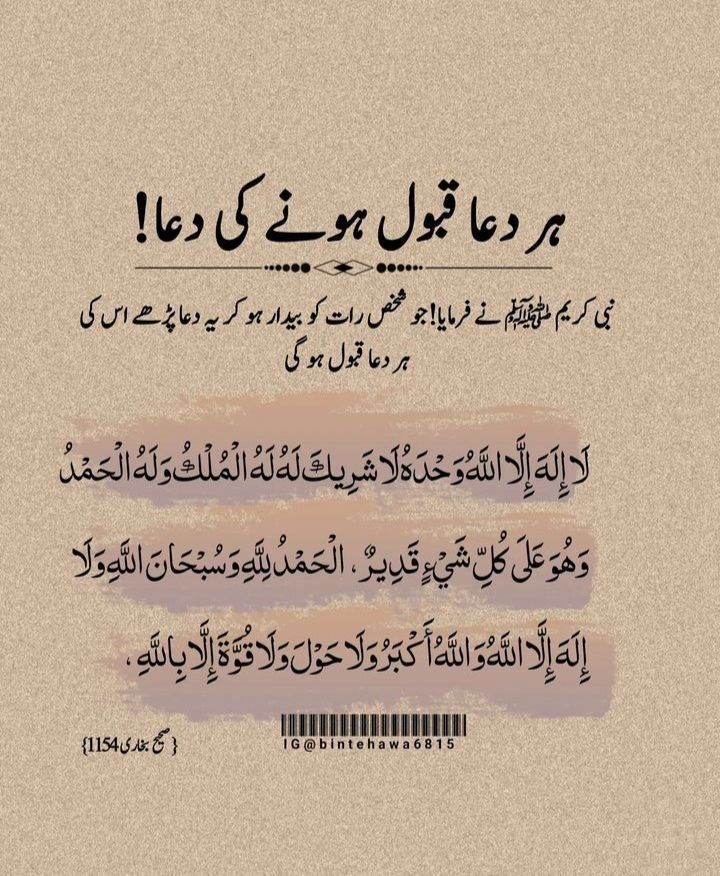

In [1]:
from IPython.display import Image

# Replace with your image path
Image(filename="/content/384507b3cfd7eea8856551733fbdebae.jpg")
